Progress Report 3: Enhanced CNN for Bounding Box Prediction with Dynamic Denoising

1. Loading and preprocessing data with infrared transformation.
2. Implementing dynamic denoising within the CNN to reduce noise impact during training.
3. Training the model to predict bounding boxes with denoising effect.
4. Testing and visualizing bounding box predictions to validate model effectiveness.

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Lambda
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import random

2024-10-31 10:17:04.800287: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Data Loading and Preprocessing

In [ ]:
BASE_DIR = './new_data/resized_images'
NOISE_FOLDERS = ['high_noise', 'little_noise', 'moderate_noise', 'infared']
annotation_file = os.path.join(BASE_DIR, 'combined_annotations.csv')

def load_data_with_noise(annotation_file, base_dir=BASE_DIR, noise_folders=NOISE_FOLDERS):
    annotations = pd.read_csv(annotation_file)
    images = []
    labels = []
    image_types = []
    
    # Include base directory key in source_counts
    source_counts = {folder: 0 for folder in noise_folders}
    source_counts['train_data'] = 0
    source_counts[os.path.basename(base_dir)] = 0  # Adding 'resized_images' key

    for _, row in annotations.iterrows():
        img_filename = row['filename']
        folder_choice = random.choice([base_dir] + [os.path.join(base_dir, folder) for folder in noise_folders])
        img_path = os.path.join(folder_choice, img_filename)
        
        if not os.path.exists(img_path):
            img_path = os.path.join(base_dir, img_filename)
            source_counts['train_data'] += 1
            image_type = 'base'
        else:
            folder_key = os.path.basename(folder_choice)
            source_counts[folder_key] += 1
            image_type = folder_key
        
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if image is not None:
            image = cv2.resize(image, (512, 512))
            images.append(image[..., np.newaxis])
            labels.append([row['xmin'] / 512, row['ymin'] / 512, row['xmax'] / 512, row['ymax'] / 512])
            image_types.append(image_type)
    
    print("Data loaded from each source:", source_counts)
    return np.array(images) / 255.0, np.array(labels), image_types

images, labels, image_types = load_data_with_noise(annotation_file)
x_train, x_test, y_train, y_test, train_types, test_types = train_test_split(
    images, labels, image_types, test_size=0.2, random_state=42)

print(f'Training samples: {x_train.shape[0]}, Testing samples: {x_test.shape[0]}')


Data loaded from each source: {'high_noise': 36, 'little_noise': 31, 'moderate_noise': 31, 'train_data': 0, 'resized_images': 27}
Training samples: 100, Testing samples: 25


In [5]:
from tensorflow.keras.layers import Input, Lambda, Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout

Dynamic Denoising Layer

In [10]:
# Dynamic denoising function with print statement to indicate usage
def dynamic_denoise_layer(inputs):
    def denoise(image):
        variance = tf.image.total_variation(image)
        threshold = 5000  # Example threshold

        smoothed_image = tf.nn.conv2d(tf.expand_dims(image, 0), 
                                      filters=tf.constant([[1, 2, 1], [2, 4, 2], [1, 2, 1]], dtype=tf.float32)[..., np.newaxis, np.newaxis],
                                      strides=1, padding='SAME')
        smoothed_image = tf.squeeze(smoothed_image, axis=0)  # Remove batch dimension

        return tf.where(variance > threshold, smoothed_image, image)
    
    return tf.map_fn(denoise, inputs)


Building and Compiling the CNN Model with Denoising

In [11]:
# Model definition
def create_model(input_shape=(512, 512, 1)):  # Updated for grayscale
    inputs = Input(shape=input_shape)
    x = Lambda(dynamic_denoise_layer, output_shape=input_shape)(inputs)

    # Convolutional layers
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)

    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = Dense(256, activation='relu')(x)
    outputs = Dense(4, activation='linear')(x)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    return model

# Create and summarize the model
model = create_model()
#model.summary()

Training the Model

In [12]:
datagen = ImageDataGenerator(rotation_range=10, width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
history = model.fit(datagen.flow(x_train, y_train, batch_size=10), epochs=20, validation_data=(x_test, y_test))

Epoch 1/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - loss: 1438.9320 - mae: 16.8457 - val_loss: 0.0534 - val_mae: 0.1843
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - loss: 0.0519 - mae: 0.1786 - val_loss: 0.0518 - val_mae: 0.1780
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - loss: 0.0325 - mae: 0.1418 - val_loss: 0.0425 - val_mae: 0.1663
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - loss: 0.0417 - mae: 0.1641 - val_loss: 0.0563 - val_mae: 0.1886
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - loss: 0.0705 - mae: 0.2050 - val_loss: 0.0417 - val_mae: 0.1533
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - loss: 0.0334 - mae: 0.1447 - val_loss: 0.0389 - val_mae: 0.1512
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - loss: 0.0341 - mae: 0.1416 - val_loss: 0.0486 - val_mae: 0.1680
Epoch 8/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - loss: 0.0458 - mae: 0.1706 - val_loss: 0.1011 - val_mae: 0.2691
Epoch 9/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - loss: 0.0804 - m

Testing and Visualizing Predictions

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 780ms/step


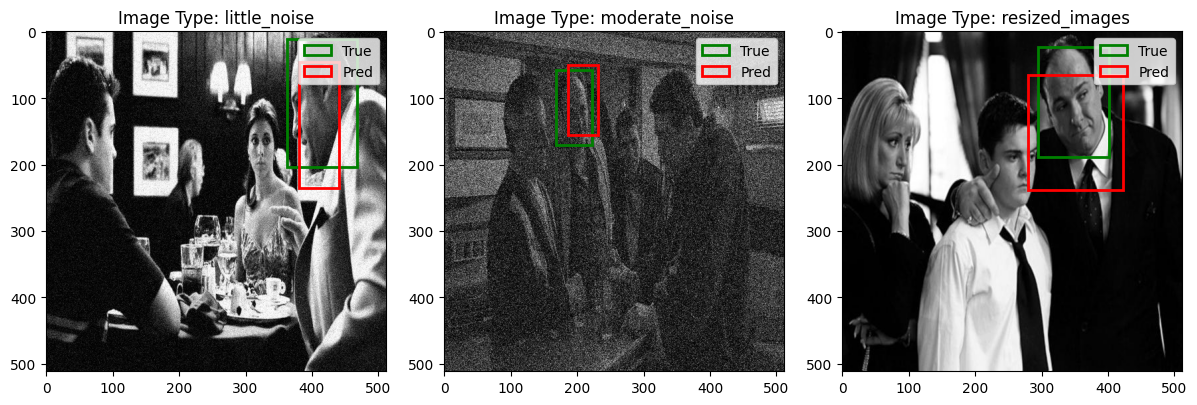

In [ ]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

def visualize_predictions(x_test, y_test, test_types, model, indices=None, show_index=False, max_images_per_row=3):
    preds = model.predict(x_test) * 512  # Scale predictions back to pixel values
    y_test = y_test * 512  # Scale ground truth labels back to pixel values
    
    # Use specified indices if provided, else default to the first 5 indices
    if indices is None:
        indices = range(min(5, len(x_test)))
    
    num_images = len(indices)
    num_rows = (num_images + max_images_per_row - 1) // max_images_per_row  # Calculate required rows
    
    plt.figure(figsize=(max_images_per_row * 4, num_rows * 4))  # Adjust figure size
    
    for i, idx in enumerate(indices):
        if idx >= len(x_test):  # Ensure index is within bounds
            print(f"Index {idx} is out of bounds for x_test with length {len(x_test)}")
            continue

        rgb_image = cv2.cvtColor((x_test[idx] * 255).astype(np.uint8).squeeze(), cv2.COLOR_GRAY2RGB)
        plt.subplot(num_rows, max_images_per_row, i + 1)
        plt.imshow(rgb_image)
        
        # Display title with optional index
        title = f'Image Type: {test_types[idx]}'
        if show_index:
            title = f'Index {idx} - ' + title
        plt.title(title)
        
        # Draw true bounding box (green)
        plt.gca().add_patch(
            plt.Rectangle((y_test[idx][0], y_test[idx][1]), y_test[idx][2] - y_test[idx][0], y_test[idx][3] - y_test[idx][1],
                          edgecolor='g', lw=2, fill=False, label='True')
        )
        
        # Draw predicted bounding box (red)
        plt.gca().add_patch(
            plt.Rectangle((preds[idx][0], preds[idx][1]), preds[idx][2] - preds[idx][0], preds[idx][3] - preds[idx][1],
                          edgecolor='r', lw=2, fill=False, label='Pred')
        )
        
        plt.legend(['True', 'Pred'], loc='upper right')
    
    plt.tight_layout()
    plt.show()

# Example usage with optional flags and max_images_per_row adjustment
visualize_predictions(x_test, y_test, test_types, model, indices=[1,2,3], show_index=False, max_images_per_row=4)
